# AirBnB London Covid-19 analysis

Let's load the libraries and start looking through the data.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## 1. Business understanding

As the world is still gripped in a pandemic due to the Covid-19, I was wondering what are the effects on the AirBnb listed properties in London. I choose London as this is a city that I have lived quite close to for a number of years.

I was mainly interested in three different questions:
1. Is there a reduction in bookings and how much?
2. Is there an impact on the prices of AirBnb accommodation in London?
3. Is there a difference in the effect on properties with higher ratings?

I know that data analysis on Covid-19 effects have been overwhelming and everywhere a person looks at — from the news to Twitter and Facebook. Even with that in mind I was thinking that there might be some interesting outcomes that we can draw from the data.

## 2. Walk through the data

Read the historical datasets, making sure to only read .csv files via a filter

In [3]:
FILES = os.listdir('./')
FILES = list(filter(lambda f: f.endswith('.csv'), FILES))

Get datafiles for Jan 2020 and Jan 2021 to compare

In [4]:
data_set_2021 = pd.read_csv([e for e in FILES if e.find('Jan_2021') != -1][0])

In [5]:
data_set_2020 = pd.read_csv([e for e in FILES if e.find('Jan_2020') != -1][0])

In [6]:
data_set_2021.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Arty and Bright London Apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,89,2,192,2020-03-26,1.46,3,344
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,40,1,21,2020-02-22,0.17,2,364
2,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,75,10,89,2020-03-16,0.66,1,189
3,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,307,4,42,2019-11-02,0.35,15,240
4,17506,Boutique Chelsea/Fulham Double bed 5-star ensuite,67915,Charlotte,NaN,Hammersmith and Fulham,51.47935,-0.19743,Private room,150,3,0,NaN,NaN,2,364


## 3. Data cleaning and exploring of the usefull data

Let's first remove data which is meaningless for our anaylis - ids, names of hosts, latitude and longitude. 

In [7]:
data_set_2020 = data_set_2020.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'latitude', 'longitude'])
data_set_2021 = data_set_2021.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'latitude', 'longitude'])

Let's first find NaNs and impute data for these NaNs

In [8]:
full_columns = set(data_set_2021.loc[:,:].columns) - set(data_set_2021.loc[:, data_set_2021.isnull().any()].columns)
nan_columns_2020 = set(data_set_2020.columns[data_set_2020.isnull().mean() > 0])
nan_columns_2021 = set(data_set_2021.columns[data_set_2021.isnull().mean() > 0])
print(f'These columns have missing data: {nan_columns_2020} for the 2020 dataset and {nan_columns_2021} for 2021')

These columns have missing data: {'last_review', 'reviews_per_month'} for the 2020 dataset and {'last_review', 'reviews_per_month'} for 2021


It seems that missing data is only in the review section of the data. I would imagine that this is due to properties having no reviews, which means that I would impute the NaNs with 0s. 

In [9]:
for column in nan_columns_2020:
    data_set_2020[column] = data_set_2020[column].fillna(0)
    data_set_2021[column] = data_set_2021[column].fillna(0)

Data is cleared, now move on to answering the questions outlined above. 

A few function declarations that will help wiht plotting and displaying mean values to reduce repetitions - I like these to usually be towards the top of the code block. 

In [10]:
def bar_plot(df_2020, df_2021, column: str, plot_limit=100) -> None:
    """Function which plots bar plots for a comparison between the 2 datasets
    
    Parameters: 
    df_2020: data frame for 2020 data
    df_2021: data frame for 2021 data
    column: column name 
    plot_limit: limit the plot to the most common values, default = 100
    
    Returns: 
    None
    
    """
    
    plt.subplot(121)
    (df_2020[column].value_counts()[:plot_limit]/df_2020.shape[0]).plot(kind="bar");
    plt.title(f"{column} 2021");
    plt.grid()
    plt.subplot(122)
    (df_2021[column].value_counts()[:plot_limit]/df_2021.shape[0]).plot(kind="bar");
    plt.title(f"{column} 2020");
    plt.grid()
    

In [11]:
def mean_print_plot(df_2020, df_2021, category: str, data_col: str) -> None:
    """Function which prints the mean of each category in a data column and plots the difference between the 2 datasets
    
    Parameters: 
    df_2020: data frame for 2020 data
    df_2021: data frame for 2021 data
    category: category name
    data_col: data to calculate mean on
    
    Returns: 
    None
    
    """
    
    print(f"2020 data stats: {df_2020.groupby([category]).mean()[data_col].sort_index()}")
    print('------------------------------------------------')
    print(f"2021 data stats: {df_2021.groupby([category]).mean()[data_col].sort_index()}")
    
    plt.plot(df_2020.groupby([category]).mean()[data_col].sort_index(), label='2020')
    plt.plot(df_2021.groupby([category]).mean()[data_col].sort_index(), label='2021')
    plt.title(f'Mean of {data_col} per {category} category')
    plt.legend()

Let's first look at the data that we have. Is there a reduction in the total listings between Jan 2020 and Jan 2021.

In [12]:
print(f'There are {data_set_2020.shape[0] - data_set_2021.shape[0]} less listings in Jan 2021 compared to a year earlier.')
print(f'This is a percentage reduction of {((data_set_2020.shape[0] - data_set_2021.shape[0])/data_set_2020.shape[0]) * 100}%')

There are 9123 less listings in Jan 2021 compared to a year earlier.
This is a percentage reduction of 10.550601949831732%


Now lets have a look if there are differences in type of accomodation offered and neighbourhoods

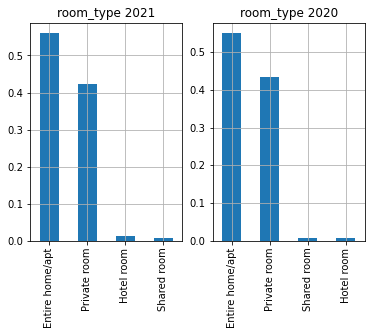

In [13]:
bar_plot(data_set_2020, data_set_2021, 'room_type')

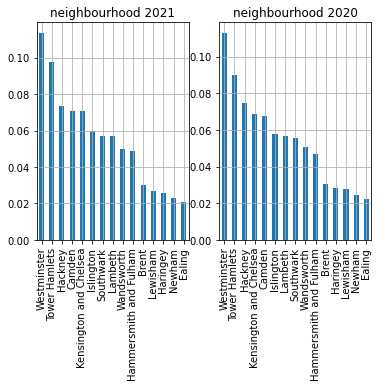

In [14]:
bar_plot(data_set_2020, data_set_2021, 'neighbourhood', plot_limit=15)

It looks like both the type and location of the offered accomodations have not changed dramatically over the course of 1 year between January 2020 and January 2021.

## 4. Answering the questions - finally

### (1) Is there a reduction in occupancy

The datasets do not include the number of bookings, so I am usning AirBnB's model to estimate bookings - by assuming that number of reviews is directly proportional to bookings. Thus the data analysis will be only looking at reviews per month.

2020 data stats: room_type
Entire home/apt    0.809616
Hotel room         0.851848
Private room       1.037548
Shared room        0.794643
Name: reviews_per_month, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    0.390338
Hotel room         0.467452
Private room       0.464382
Shared room        0.367353
Name: reviews_per_month, dtype: float64


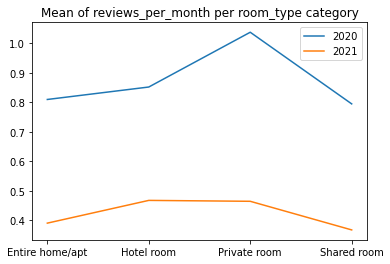

In [15]:
mean_print_plot(data_set_2020, data_set_2021, category='room_type', data_col='reviews_per_month')

In [16]:
print(f"Average number of reviews of the different accomodation types for 2020 are: {data_set_2020.groupby(['room_type']).mean()['reviews_per_month'].sort_values()}")

Average number of reviews of the different accomodation types for 2020 are: room_type
Shared room        0.794643
Entire home/apt    0.809616
Hotel room         0.851848
Private room       1.037548
Name: reviews_per_month, dtype: float64


Text(0.5, 1.0, 'Jan 2021 Data')

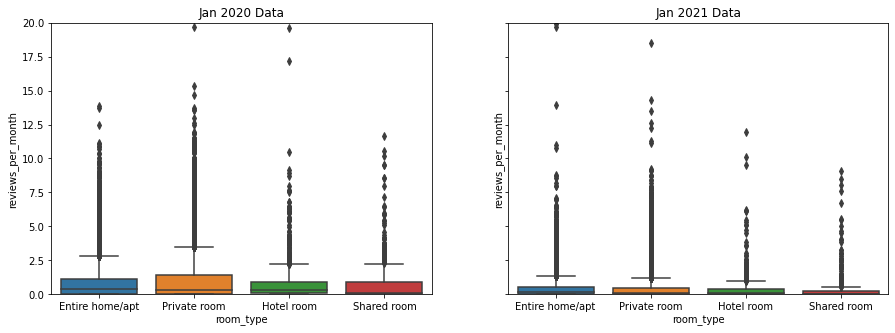

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxplot(ax = axes[0], x="room_type", y="reviews_per_month", data=data_set_2020)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 20])
sns.boxplot(ax = axes[1], x="room_type", y="reviews_per_month", data=data_set_2021)
axes[1].set_title('Jan 2021 Data')

Using the reviews to estimate occupancy (the same method for esitmating occupancy as Airbnb's "San Francisco Model") we can see that occupancy has fallen with about 50% between Jan 2020 and Jan 2021, while availability is on average around 8% larger in 2021. Towards the end of the Notebook we will see if the highly reviewed places are seeing the same drop in occupancy.

### (2) Are AirBnB's properties cheaper? 

Let's check the second question - is there a reduction of price in the year between Jan 2020 and Jan 2021. 

Text(0.5, 1.0, 'Jan 2021 Data')

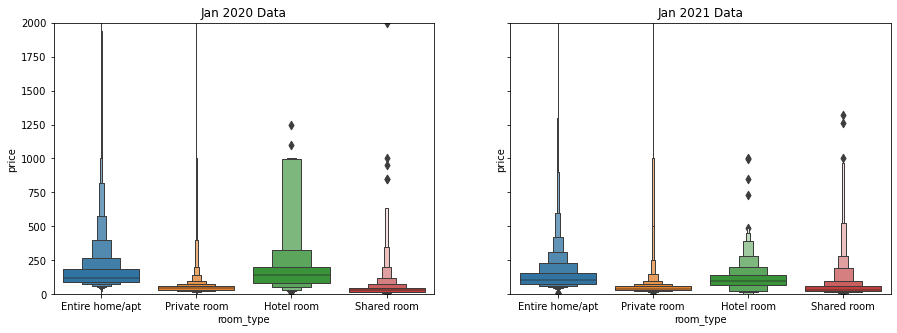

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxenplot(ax = axes[0], x="room_type", y="price", data=data_set_2020)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 2000])
sns.boxenplot(ax = axes[1], x="room_type", y="price", data=data_set_2021)
axes[1].set_title('Jan 2021 Data')

2020 data stats: room_type
Entire home/apt    176.430570
Hotel room         240.954309
Private room        59.429882
Shared room         55.371753
Name: price, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    164.784224
Hotel room         120.619546
Private room        60.251701
Shared room         75.961474
Name: price, dtype: float64


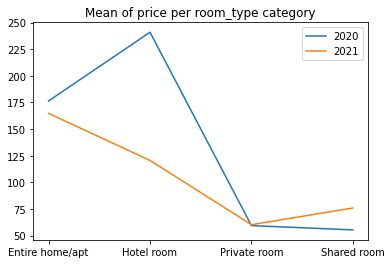

In [19]:
mean_print_plot(data_set_2020, data_set_2021, category='room_type', data_col='price')

At least from the average of the price per accomodation type we can see that apart from hotels the average cost of the accomodations has not reduced, but rather has increased in the year between Jan 2020 and Jan 2021. Let's see if this correlates with the high rated properties.

### (3) Are we seeing the same trends for the highly reviewed properties? 

In [20]:
print(f"We take the high reviewed properties as those whose review counts are larger than the \
        mean + 1 std of the number of reviews, for 2020 this number is: \
        {data_set_2020['number_of_reviews'].mean() + data_set_2020['number_of_reviews'].std()} \
        and for 2021 - {data_set_2021['number_of_reviews'].mean() + data_set_2021['number_of_reviews'].std()}")

We take the high reviewed properties as those whose review counts are larger than the         mean + 1 std of the number of reviews, for 2020 this number is:         54.61714087069369         and for 2021 - 50.71210270108489


Let's first check if there would be a visual representation of a shift of bookings towards more reviewed properties

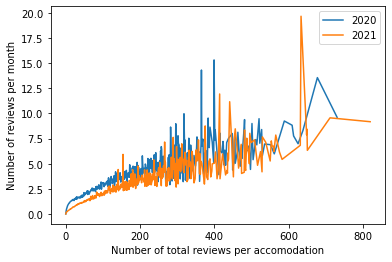

In [21]:
plt.plot(data_set_2020.groupby(['number_of_reviews']).mean()['reviews_per_month'].sort_index(), label='2020')
plt.plot(data_set_2021.groupby(['number_of_reviews']).mean()['reviews_per_month'].sort_index(), label='2021')
plt.xlabel('Number of total reviews per accomodation')
plt.ylabel('Number of reviews per month')

plt.legend()

We can see a slight shift in people booking higher reviewed accomodations more in 2021, compared to 2020, but how do the occupancy relate to the total reviews per accomodation.

In [22]:
df_2020_highreview = data_set_2020[data_set_2020['number_of_reviews'] > (data_set_2020['number_of_reviews'].mean() + 
                                  data_set_2020['number_of_reviews'].std())]
df_2021_highreview = data_set_2021[data_set_2021['number_of_reviews'] > (data_set_2021['number_of_reviews'].mean() + 
                                  data_set_2021['number_of_reviews'].std())]

2020 data stats: room_type
Entire home/apt    2.326897
Hotel room         4.810185
Private room       3.362170
Shared room        4.389038
Name: reviews_per_month, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    1.702541
Hotel room         3.734286
Private room       2.377570
Shared room        3.381842
Name: reviews_per_month, dtype: float64


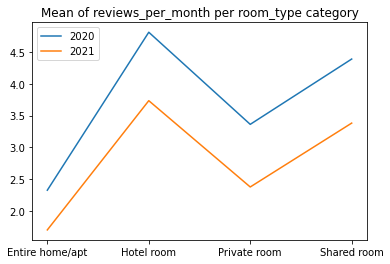

In [23]:
mean_print_plot(df_2020_highreview, df_2021_highreview, category='room_type', data_col='reviews_per_month')

From this analysis we can see that there is a drop in reviews - and thus occupancy for the highly reviewed properties, but the drop is lower than that for the general accomodations - we notice about 25% drop in these cases.

2020 data stats: room_type
Entire home/apt    134.223321
Hotel room         216.074074
Private room        50.651966
Shared room         24.134615
Name: price, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    141.400000
Hotel room          66.114286
Private room        46.591930
Shared room         54.078947
Name: price, dtype: float64


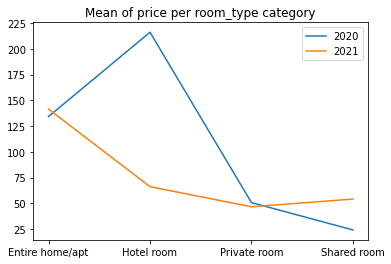

In [24]:
mean_print_plot(df_2020_highreview, df_2021_highreview, category='room_type', data_col='price')

Text(0.5, 1.0, 'Jan 2021 Data')

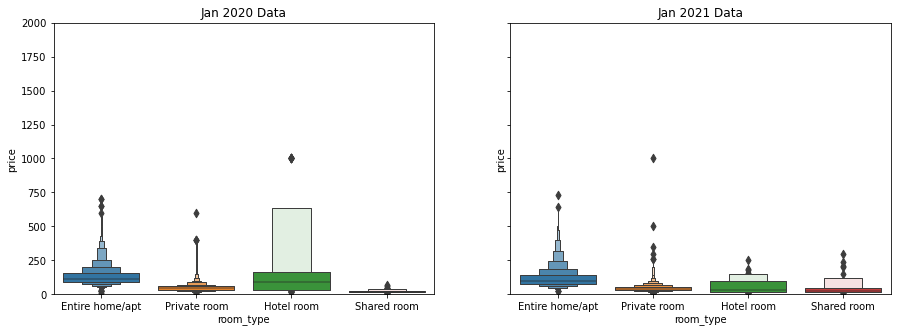

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxenplot(ax = axes[0], x="room_type", y="price", data=df_2020_highreview)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 2000])
sns.boxenplot(ax = axes[1], x="room_type", y="price", data=df_2021_highreview)
axes[1].set_title('Jan 2021 Data')

So it looks like the prices for shared rooms went up about 100%, while the hotel proces went down by 3 times. This can be explained by the fact that during the pandemic hotels were closed and/or have reduced prices to attract more clients. Let's look if these numbers are correlated with an increased minimum stay.

<AxesSubplot:>

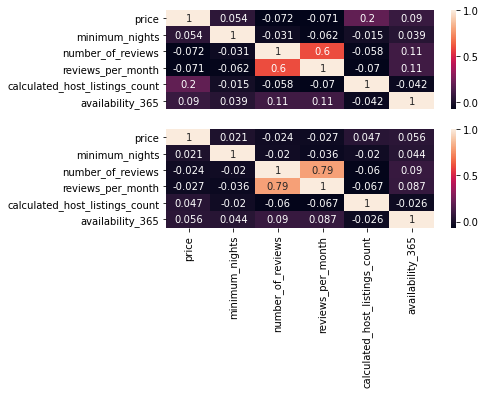

In [26]:
plt.subplot(211)
sns.heatmap(data_set_2020.corr(), annot=True, xticklabels=False)
plt.subplot(212)
sns.heatmap(data_set_2021.corr(), annot=True)

No real correlation can be seen between minimum nights and price for either 2020 and 2021, I will continue looking through the minimum nights data, but I am not confident there would be any correlation between prices and minimum night requirement 

2020 data stats: room_type
Entire home/apt    4.701612
Hotel room         5.175493
Private room       3.511997
Shared room        2.774351
Name: minimum_nights, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    5.567084
Hotel room         2.068063
Private room       4.841628
Shared room        4.251256
Name: minimum_nights, dtype: float64


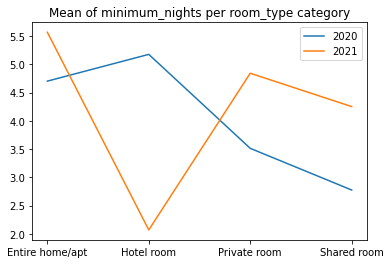

In [27]:
mean_print_plot(data_set_2020, data_set_2021, category='room_type', data_col='minimum_nights')

So it looks like that there was a considerable increase of minimum nights for shared rooms and a considerable decrease of minimum night requirement for the hotel, that can explain the difference in prices.


2020 data stats: room_type
Entire home/apt    4.148743
Hotel room         1.444444
Private room       2.000217
Shared room        1.230769
Name: minimum_nights, dtype: float64
------------------------------------------------
2021 data stats: room_type
Entire home/apt    5.862810
Hotel room         1.285714
Private room       2.685422
Shared room        1.210526
Name: minimum_nights, dtype: float64


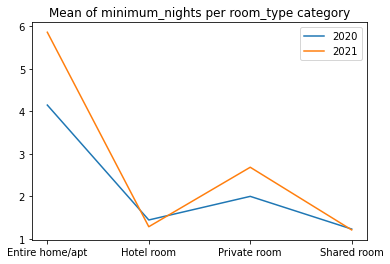

In [28]:
mean_print_plot(df_2020_highreview, df_2021_highreview, category='room_type', data_col='minimum_nights')

So it looks like that there is no major difference in the minimum nights requirement for the highly reviewed properties. It looks like the price increase for the shared room category is not correlated with the minimum nights occupied. 

## 5. Conclusions

So it does look as the Covid-19 pandemic had an effect on AirBnB properties in London. 

1. Overall bookings were down with more than 50%
2. Only hotel prices were down by about 50%, they went up on some categories of properties.
3. Bookings on hihghly rated properties were down only about 25%, however the price trend was the same as in the overall case

This analysis also looked at if there would be a correlation between the higher prices in 2021 and the minimum night requirements. Such link was not discovered. 

The analysis will be extended with a more granular analysis over individual months between Jan 2020 and Jan 2021. 